# Setup
Først skal vi importere alle vores dependencies hvorefter vi klargør forbindelsen til google storage hvor billederne er pladseret

In [1]:
# Common imports
import sys
import os
import random
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import PIL
from google.cloud import storage

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Google Cloud Storage Variabler
bucket_name = 'iot-lego-sorter.appspot.com'
folder = 'datasets'
storage_client = storage.Client.from_service_account_json('service_account.json')
bucket = storage_client.bucket(bucket_name)

# Foldere lokalt
localDir = 'images/lego/'

# Billede Dimensioner
imgWidth = 64
imgHeight = 64
print('Done')

Done


# Download Filerne fra Goolge-Storage
Her henter vi alle billederne samt gemmer dem lokalt på disken 

In [2]:
blobs = storage_client.list_blobs(bucket_name, prefix=folder)
fileNameByBrickId = {}

for blob in blobs:
    nameNoFolder = blob.name[len(folder)+1:]
    split = nameNoFolder.split('/')
    if(len(split) > 1):
        id = split[0];
        fileDir = blob.name;
        if(id in fileNameByBrickId):
            fileNameByBrickId[id].append(fileDir)
        else:
            fileNameByBrickId[id] = [fileDir]

In [3]:
def downloadFile(fileName):
    nameNoFolder = fileName[len(folder)+1:]
    testFileDir = localDir + nameNoFolder
    testDir = os.path.dirname(testFileDir)
    if not os.path.isfile(testFileDir):
        if not os.path.exists(testDir):
            os.makedirs(testDir)
        blob = bucket.blob(fileName)
        blob.download_to_filename(testFileDir)
    
    return testFileDir

In [4]:
localFileNameByBrickId = {}
for key in fileNameByBrickId.keys():
    localFileNameByBrickId[key] = []
    listLenStr = str(len(fileNameByBrickId[key]))
    for index, fileName in enumerate(fileNameByBrickId[key]):
        localFileNameByBrickId[key].append(downloadFile(fileName))

# Omformatere billederne til multidimensionel arrays

In [5]:
def convertImageToArray(fileName):
    an_image = PIL.Image.open(fileName)
    image_sequence = an_image.getdata()
    return np.array(image_sequence).reshape(imgWidth, imgHeight)

In [6]:
IndexToBrickId = {}
brickIdImageKeyPairs = []
brickIdImageKeyPairs_beltValidation = []

for index, key in enumerate(localFileNameByBrickId.keys()):
    IndexToBrickId[index] = key
    listLenStr = str(len(localFileNameByBrickId[key]))
    for index2, fileName in enumerate(localFileNameByBrickId[key]):
        if '_belt' in fileName:
            brickIdImageKeyPairs_beltValidation.append((index, convertImageToArray(fileName)))
        else:
            brickIdImageKeyPairs.append((index, convertImageToArray(fileName)))

# Put Billederne i tilfældig ordre
Da dataene skal splittes så man kan generere en Train/Validation/Test set så er det vigtigt at rækkefølgen er tilfældig

In [7]:
brickIdIndexes = []
images = []

brickIdIndexes_belt = []
images_belt = []

random.shuffle(brickIdImageKeyPairs)
for item in brickIdImageKeyPairs:
    brickIdIndexes.append(item[0])
    images.append(item[1])

for item in brickIdImageKeyPairs_beltValidation:
    brickIdIndexes_belt.append(item[0])
    images_belt.append(item[1])


# Split Datasæt Training / Test / Validation
![Dataset](LegoDataset.PNG)

In [8]:
#Udregn mængden af billeder der skal allokeres til Train og Test
percentageToTakeTrainFull = int(len(brickIdIndexes) * 0.8)

#Opret et trænings set til at træne modellen
X_train = np.asarray(images[:percentageToTakeTrainFull])
y_train = np.asarray(brickIdIndexes[:percentageToTakeTrainFull])

#Opræt en test set for at kunne evaluere modellen
#Først tage fra de originale dataset
X_testData = images[percentageToTakeTrainFull:]
y_testData = brickIdIndexes[percentageToTakeTrainFull:]
#Herefter tag billederne fra samlebåndet og tilføj dem for at bekræfte effektivitet på rigtige billeder
X_testData.extend(images_belt)
y_testData.extend(brickIdIndexes_belt)
#Konvertere billederne til et NumpyArray
X_test = np.asarray(X_testData)
y_test = np.asarray(y_testData)


In [9]:
#Dividere med 255 for at normalisere dataene
X_train = X_train / 255.0
X_test = X_test / 255.0

# RandomSearchCV
Fomålet her er at danne et overblik over hvilke parametre der vil egne sig bedst til denne model. Dette bliver gjordt ved at lave en metode der retunere en model hvor metoden tager det ønsket input som parametre. Herefter kan vi på en iterativ måde køre forskellige kombinationer og test hvilke parametre der egener sig bedst

In [10]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, optimizer='Adam', activation='relu'):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[64,64]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation))
    model.add(keras.layers.Dense(3, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.optimizer.lr = learning_rate
    return model

In [11]:
keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [12]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {
    "n_hidden": [1 ,2 ,3, 4],
    "n_neurons": np.arange(10,100),
    "learning_rate": [5e-4, 5e-3, 5e-2, 5e-1],
    "optimizer": ['Adam', 'SGD'],
    "activation": ['relu', 'selu']
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=50,
                  validation_split=0.2,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10, 
                                                  monitor='val_accuracy', 
                                                  mode='max',
                                                  min_delta=0.1,
                                                  restore_best_weights=True)])

Epoch 1/50
60/60 [==============================] - 0s 4ms/step - loss: 2.0503 - accuracy: 0.3391 - val_loss: 1.0979 - val_accuracy: 0.3701
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 1.0961 - accuracy: 0.3547 - val_loss: 1.1007 - val_accuracy: 0.2973
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 1.0943 - accuracy: 0.3526 - val_loss: 1.1025 - val_accuracy: 0.2973
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 1.0940 - accuracy: 0.3667 - val_loss: 1.1056 - val_accuracy: 0.2973
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 1.0939 - accuracy: 0.3667 - val_loss: 1.1048 - val_accuracy: 0.2973
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 1.0941 - accuracy: 0.3479 - val_loss: 1.1050 - val_accuracy: 0.2973
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 1.0938 - accuracy: 0.3667 - val_loss: 1.1057 - val_accuracy: 0.2973
Epoch 8/50
60/60 [==

Epoch 11/50
38/38 [==============================] - 0s 710us/step - loss: 1.3138 - accuracy: 0.3292
Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 10325.4082 - accuracy: 0.3078 - val_loss: 74.6720 - val_accuracy: 0.3701
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 45.6434 - accuracy: 0.3318 - val_loss: 65.2998 - val_accuracy: 0.2973
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 44.5030 - accuracy: 0.3307 - val_loss: 73.6831 - val_accuracy: 0.3701
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 44.3351 - accuracy: 0.3375 - val_loss: 48.7289 - val_accuracy: 0.2973
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 44.4188 - accuracy: 0.3344 - val_loss: 28.1743 - val_accuracy: 0.3326
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 44.9038 - accuracy: 0.3250 - val_loss: 34.6364 - val_accuracy: 0.3326
Epoch 7/50
60/60 [==========================

Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 0.9171 - accuracy: 0.5859 - val_loss: 0.8125 - val_accuracy: 0.7547
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 0.7577 - accuracy: 0.7083 - val_loss: 0.6741 - val_accuracy: 0.8025
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.8042 - val_loss: 0.5802 - val_accuracy: 0.6861
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 0.4550 - accuracy: 0.8448 - val_loss: 0.3785 - val_accuracy: 0.8857
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 0.2547 - accuracy: 0.9349 - val_loss: 0.1997 - val_accuracy: 0.9501
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 0.2149 - accuracy: 0.9344 - val_loss: 0.1647 - val_accuracy: 0.9439
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 0.2347 - accuracy: 0.9276 - val_loss: 0.1167 - val_accuracy: 0.9896
Epoch 9/50
60/60 [==

Epoch 10/50
60/60 [==============================] - 0s 1ms/step - loss: 0.1253 - accuracy: 0.9823 - val_loss: 0.1124 - val_accuracy: 1.0000
Epoch 11/50
60/60 [==============================] - 0s 1ms/step - loss: 0.1188 - accuracy: 0.9766 - val_loss: 0.1141 - val_accuracy: 0.9896
Epoch 12/50
60/60 [==============================] - 0s 1ms/step - loss: 0.0925 - accuracy: 0.9906 - val_loss: 0.1360 - val_accuracy: 0.9854
Epoch 13/50
60/60 [==============================] - 0s 1ms/step - loss: 0.0910 - accuracy: 0.9833 - val_loss: 0.0717 - val_accuracy: 0.9979
Epoch 14/50
60/60 [==============================] - 0s 1ms/step - loss: 0.0719 - accuracy: 0.9948 - val_loss: 0.0763 - val_accuracy: 1.0000
Epoch 15/50
60/60 [==============================] - 0s 1ms/step - loss: 0.0968 - accuracy: 0.9719 - val_loss: 0.1084 - val_accuracy: 0.9875
Epoch 16/50
60/60 [==============================] - 0s 1ms/step - loss: 0.0710 - accuracy: 0.9849 - val_loss: 0.0472 - val_accuracy: 1.0000
Epoch 17/50
6

60/60 [==============================] - 0s 3ms/step - loss: 26026.0352 - accuracy: 0.3349 - val_loss: 7.0584 - val_accuracy: 0.3326
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 7.5997 - accuracy: 0.3146 - val_loss: 5.0923 - val_accuracy: 0.3701
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 2.4916 - accuracy: 0.3411 - val_loss: 9.2080 - val_accuracy: 0.2973
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 4.3304 - accuracy: 0.3281 - val_loss: 9.3368 - val_accuracy: 0.3326
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 8.0148 - accuracy: 0.3391 - val_loss: 3.6294 - val_accuracy: 0.3326
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 6.2202 - accuracy: 0.3385 - val_loss: 2.8612 - val_accuracy: 0.3701
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 5.5114 - accuracy: 0.3286 - val_loss: 2.7253 - val_accuracy: 0.2973
Epoch 8/50
60/60 [=========

Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 1.1504 - accuracy: 0.3339 - val_loss: 1.1361 - val_accuracy: 0.3701
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: 1.3060 - accuracy: 0.3354 - val_loss: 1.4212 - val_accuracy: 0.2973
Epoch 10/50
60/60 [==============================] - 0s 2ms/step - loss: 1.2058 - accuracy: 0.3490 - val_loss: 1.1191 - val_accuracy: 0.3326
Epoch 11/50
38/38 [==============================] - 0s 921us/step - loss: 1.2455 - accuracy: 0.3364
Epoch 1/50
61/61 [==============================] - 0s 3ms/step - loss: 28.7470 - accuracy: 0.3431 - val_loss: 1.8202 - val_accuracy: 0.2952
Epoch 2/50
61/61 [==============================] - 0s 2ms/step - loss: 1.3049 - accuracy: 0.3352 - val_loss: 1.2578 - val_accuracy: 0.3846
Epoch 3/50
61/61 [==============================] - 0s 2ms/step - loss: 1.1992 - accuracy: 0.3519 - val_loss: 1.3370 - val_accuracy: 0.3846
Epoch 4/50
61/61 [==============================] - 0s 2m

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001EE7E289A88>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'activation': ['relu', 'selu'],
                                        'learning_rate': [0.0005, 0.005, 0.05,
                                                          0.5],
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2...
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99]),
                                        'optimize

In [13]:
rnd_search_cv.best_params_

{'optimizer': 'Adam',
 'n_neurons': 46,
 'n_hidden': 2,
 'learning_rate': 0.0005,
 'activation': 'relu'}

In [14]:
randomCV_model = rnd_search_cv.best_estimator_.model
randomCV_model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 969us/step - loss: 0.4354 - accuracy: 0.9081


[0.43535953760147095, 0.9081239442825317]

# Udarbejd Modellen baseret på tidligere resultat
Ved at bruge det tidligere resultat som et udgangspunkt så kan vi herefter fintune og ændre på ting så vores accuracy på vores evaluering bliver så høj som overhovedet mulig

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[64, 64]))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Dense(3, activation="softmax"))

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_90 (Dense)             (None, 50)                204850    
_________________________________________________________________
dense_91 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_92 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 3)                 153       
Total params: 210,103
Trainable params: 210,103
Non-trainable params: 0
_______________________________________________

In [16]:
#Define optimizer with learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

#Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [17]:
#Define early stopping to prevent overfitting
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, 
                                                  monitor='val_accuracy', 
                                                  mode='max',
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
#Define Learning rate schedule make learning rate adaptive
learning_rate = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Træn Modellen
Efter vi har defineret modellen så er det tid til at træne den

In [18]:
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32, 
                    callbacks=[early_stopping_cb, learning_rate])

Epoch 1/50
91/91 [==============================] - 0s 3ms/step - loss: 1.0751 - accuracy: 0.4398 - val_loss: 0.9710 - val_accuracy: 0.5409
Epoch 2/50
91/91 [==============================] - 0s 2ms/step - loss: 0.9406 - accuracy: 0.5831 - val_loss: 0.7940 - val_accuracy: 0.7309
Epoch 3/50
91/91 [==============================] - 0s 2ms/step - loss: 0.6351 - accuracy: 0.7605 - val_loss: 0.5963 - val_accuracy: 0.6685
Epoch 4/50
91/91 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.8664 - val_loss: 0.2929 - val_accuracy: 0.9806
Epoch 5/50
91/91 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.9209 - val_loss: 0.2076 - val_accuracy: 0.9834
Epoch 6/50
91/91 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.9483 - val_loss: 0.1487 - val_accuracy: 0.9584
Epoch 7/50
91/91 [==============================] - 0s 2ms/step - loss: 0.1564 - accuracy: 0.9563 - val_loss: 0.0995 - val_accuracy: 0.9847
Epoch 8/50
91/91 [==

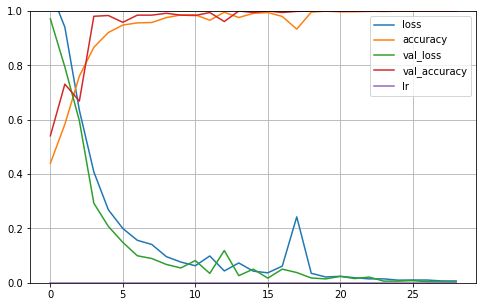

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [20]:
print('Resultater fra RandomSearchCV')
randomCV_model.evaluate(X_test, y_test, batch_size=32)
print('Resultater fra Modellen')
model.evaluate(X_test, y_test, batch_size=32)

Resultater fra RandomSearchCV
31/31 [==============================] - 0s 935us/step - loss: 0.4354 - accuracy: 0.9081
Resultater fra Modellen
31/31 [==============================] - 0s 775us/step - loss: 0.2744 - accuracy: 0.9576


[0.2743775546550751, 0.9576446413993835]